In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import re

from multiprocessing.dummy import Pool as ThreadPool
import itertools
from collections import defaultdict

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import keras

from thesis.utils.metrics import *

Using Theano backend.
Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [4]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [5]:
#NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_batch_{}_nn_parameter_searches.pkl"
NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"
# NN_PARAMETER_SEARCH_PREFIX = "standard_nn_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [6]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"

In [18]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

# nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims")
# nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_all_levels")
# nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_all_levels_2")
# nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_all_levels_3")
nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_large_sample")
# nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_large_sample_parags")
# nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_full_chunks")
# nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_full_chunks_one_model")

training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
classification_index_file = exports_location + "classification_index.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [19]:
def get_subdirectories(d):
    #return filter(os.path.isdir, [f for f in os.listdir(d)])
    return [f for f in os.listdir(d) if os.path.isdir(os.path.join(d,f))]
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [20]:
class MetricsCallback(keras.callbacks.Callback):
    
    EPOCHS_BEFORE_VALIDATION = 10
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            print '\r    \r' # to remove the previous line of verbose output of model fit
            time.sleep(0.2)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics


In [21]:
PARTS_LEVEL = 1

In [22]:
NN_BATCH_SIZE = 2048

In [23]:
classifications_type = 'sections'

In [24]:
natural_sort(get_subdirectories(nn_parameter_search_location))

['doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None']

In [25]:
table_data = defaultdict(dict)
for doc2vec_method in natural_sort(get_subdirectories(nn_parameter_search_location)):
    for epoch in natural_sort(get_subdirectories(os.path.join(nn_parameter_search_location,doc2vec_method))):
        print '*********** {} -> {}'.format(doc2vec_method, epoch)
        if not os.path.exists(os.path.join(nn_parameter_search_location, doc2vec_method, epoch, NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))):
            print 'Not found'
            continue
        try:
            %time param_results_dict = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, doc2vec_method, epoch, NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'r'))
        except:
            continue
            
        for key in param_results_dict.keys():
            print('========== NN: {}'.format(key))
            val = param_results_dict[key]
            if val.get('best_validation_metrics'):
#                 val_metrics = val['last_validation_metrics']
                val_metrics2 =  val['best_validation_metrics']
            else:
                val_metrics = val['validation_metrics']
                val_metrics2 =  val['metrics_callback'].metrics_dict[sorted(val['metrics_callback'].metrics_dict.keys())[-1]]
    
#             print('Epochs => {}'.format(len(val['history'].history['val_loss'])))
#             print('Best Val Loss => {}'.format(val["metrics_callback"].best_val_loss))
#             print('Last Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics['coverage_error'], 
#                                                                                                 val_metrics['f1_micro'], val_metrics['f1_macro'],
#                                                                                                 val_metrics['top_3']))
#             print('Best Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics2['coverage_error'], 
#                                                                                                 val_metrics2['f1_micro'], val_metrics2['f1_macro'],
#                                                                                                 val_metrics2['top_3']))
            table_data[epoch + ' / ' + key]['{} {} {} -- {}'.format(doc2vec_method[13:22], doc2vec_method[22:29], doc2vec_method[29:37], 'Epochs')] = val['epochs']
            table_data[epoch + ' / ' + key]['{} {} {} -- {}'.format(doc2vec_method[13:22], doc2vec_method[22:29], doc2vec_method[29:37], 'duration')] = val['duration']
            table_data[epoch + ' / ' + key]['{} {} {} -- {}'.format(doc2vec_method[13:22], doc2vec_method[22:29], doc2vec_method[29:37], 'best_val_loss')] = val['best_val_loss'] if 'best_val_loss' in val else 0
            table_data[epoch + ' / ' + key]['{} {} {} -- {}'.format(doc2vec_method[13:22], doc2vec_method[22:29], doc2vec_method[29:37], 'Coverage Error')] = round(val_metrics2['coverage_error'], 3)
            table_data[epoch + ' / ' + key]['{} {} {} -- {}'.format(doc2vec_method[13:22], doc2vec_method[22:29], doc2vec_method[29:37], 'F1 Micro')] = round(val_metrics2['f1_micro'], 3)
            table_data[epoch + ' / ' + key]['{} {} {} -- {}'.format(doc2vec_method[13:22], doc2vec_method[22:29], doc2vec_method[29:37], 'F1 Macro')] = round(val_metrics2['f1_macro'], 3)
            # table_data[epoch + ' / ' + key]['{} {} {} -- {}'.format(doc2vec_method[13:22], doc2vec_method[22:29], doc2vec_method[29:37], 'Precision Micro')] = round(val_metrics2['precision_micro'], 3)
            table_data[epoch + ' / ' + key]['{} {} {} -- {}'.format(doc2vec_method[13:22], doc2vec_method[22:29], doc2vec_method[29:37], 'Top 3')] = round(val_metrics2['top_3'], 3)
            table_data[epoch + ' / ' + key]['{} {} {} -- {}'.format(doc2vec_method[13:22], doc2vec_method[22:29], doc2vec_method[29:37], 'Top 5')] = round(val_metrics2['top_5'], 3)


*********** doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None -> epoch_3
Not found
*********** doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None -> epoch_8
CPU times: user 13.4 s, sys: 120 ms, total: 13.5 s
Wall time: 13.6 s
========== NN: nn_1st-size_100_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True
========== NN: nn_1st-size_500_1st-act_sigmoid_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True
========== NN: nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True
========== NN: nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True
========== NN: nn_1st-size_1000_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True
========== NN: nn_1st-size_100_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True
========== NN: nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-dr

In [27]:
table_rows = natural_sort(table_data.keys())
table_values = []
for table_row in table_rows:
    #print table_data[table_row]
    table_values.append(table_data[table_row])
df = pd.DataFrame(data=table_values, index=table_rows)
df

,200_w_2_t ype_dm_ concat_0 -- Coverage Error,200_w_2_t ype_dm_ concat_0 -- Epochs,200_w_2_t ype_dm_ concat_0 -- F1 Macro,200_w_2_t ype_dm_ concat_0 -- F1 Micro,200_w_2_t ype_dm_ concat_0 -- Top 3,200_w_2_t ype_dm_ concat_0 -- Top 5,200_w_2_t ype_dm_ concat_0 -- best_val_loss,200_w_2_t ype_dm_ concat_0 -- duration
epoch_8 / lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_None,1.647,76,0.627,0.695,0.942,0.987,0.214159,1646.562372
epoch_8 / lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_2_conv_None,1.633,52,0.631,0.701,0.947,0.989,0.200705,1046.247749
epoch_8 / lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None,1.645,68,0.626,0.694,0.942,0.988,0.213007,1592.128282
epoch_8 / nn_1st-size_100_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True,1.702,53,0.523,0.655,0.934,0.987,0.208284,68.275099
epoch_8 / nn_1st-size_100_1st-act_relu_2nd-size_None_2nd-act_tanh_in-drop_False_hid-drop_True,1.733,51,0.538,0.637,0.927,0.985,0.224628,151.103172
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True,1.747,126,0.531,0.629,0.927,0.986,0.219344,219.322216
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True,1.738,84,0.561,0.637,0.929,0.986,0.216287,96.405553
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,2.088,20,0.350,0.540,0.860,0.963,0.294530,30.827208
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_False_hid-drop_True,1.748,144,0.561,0.635,0.925,0.985,0.223020,354.903528
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True,1.748,173,0.545,0.636,0.925,0.985,0.223717,221.059956


In [94]:
df.rank(axis=0, ascending=True)

,200_w_2_t ype_dm_ concat_0 -- Coverage Error,200_w_2_t ype_dm_ concat_0 -- Epochs,200_w_2_t ype_dm_ concat_0 -- F1 Macro,200_w_2_t ype_dm_ concat_0 -- F1 Micro,200_w_2_t ype_dm_ concat_0 -- Top 3,200_w_2_t ype_dm_ concat_0 -- Top 5,200_w_2_t ype_dm_ concat_0 -- best_val_loss,200_w_2_t ype_dm_ concat_0 -- duration
epoch_8 / nn_1st-size_100_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True,19.0,5.5,3.0,4.0,3.0,2.5,19.0,3.0
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True,20.0,9.0,2.0,2.0,2.0,2.5,20.0,8.0
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,21.0,1.0,1.0,1.0,1.0,1.0,21.0,2.0
epoch_8 / nn_1st-size_100_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True,17.0,21.0,9.0,6.0,4.0,5.0,15.0,13.0
epoch_8 / nn_1st-size_100_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True,14.0,20.0,11.0,12.0,8.5,12.0,10.0,21.0
epoch_8 / nn_1st-size_200_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True,16.0,19.0,6.0,6.0,6.5,12.0,14.0,16.0
epoch_8 / nn_1st-size_200_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,18.0,2.5,4.0,3.0,5.0,5.0,18.0,4.0
epoch_8 / nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True,15.0,18.0,12.0,9.5,6.5,5.0,11.0,18.0
epoch_8 / nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,4.0,16.0,20.0,17.5,16.5,12.0,4.0,20.0
epoch_8 / nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True,7.0,7.0,14.0,14.0,16.5,12.0,7.0,6.0


In [28]:
df.filter(regex='.*w-drop_0.5_u-drop_0.5.*', axis=0)

,200_w_2_t ype_dm_ concat_0 -- Coverage Error,200_w_2_t ype_dm_ concat_0 -- Epochs,200_w_2_t ype_dm_ concat_0 -- F1 Macro,200_w_2_t ype_dm_ concat_0 -- F1 Micro,200_w_2_t ype_dm_ concat_0 -- Top 3,200_w_2_t ype_dm_ concat_0 -- Top 5,200_w_2_t ype_dm_ concat_0 -- best_val_loss,200_w_2_t ype_dm_ concat_0 -- duration
epoch_8 / lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_None,1.647,76,0.627,0.695,0.942,0.987,0.214159,1646.562372
epoch_8 / lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_2_conv_None,1.633,52,0.631,0.701,0.947,0.989,0.200705,1046.247749
epoch_8 / lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None,1.645,68,0.626,0.694,0.942,0.988,0.213007,1592.128282


In [1185]:
df.filter(regex='.*lstm.*', axis=0)

,200_w_2_t ype_dm_ concat_0 -- Coverage Error,200_w_2_t ype_dm_ concat_0 -- Epochs,200_w_2_t ype_dm_ concat_0 -- F1 Macro,200_w_2_t ype_dm_ concat_0 -- F1 Micro,200_w_2_t ype_dm_ concat_0 -- Top 3,200_w_2_t ype_dm_ concat_0 -- Top 5,200_w_2_t ype_dm_ concat_0 -- best_val_loss,200_w_2_t ype_dm_ concat_0 -- duration
epoch_3 / lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_0.2_stack_1_conv_None,1.797,55,0.570,0.638,0.915,0.979,0.228929,2681.563863
epoch_3 / lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_0.2_stack_2_conv_None,1.832,50,0.562,0.634,0.909,0.974,0.232192,4422.097599
epoch_3 / lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_None_stack_1_conv_None,1.957,25,0.451,0.563,0.882,0.972,0.255166,1228.118901
epoch_3 / lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.4_stack_1_conv_None,1.817,52,0.549,0.622,0.911,0.979,0.235744,2804.761385
epoch_3 / lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.4_stack_1_conv_None,1.965,48,0.465,0.547,0.884,0.974,0.260022,3958.523711
epoch_3 / lstm_optimizer_rmsprop_size_200_w-drop_None_u-drop_0.2_stack_1_conv_None,1.888,31,0.565,0.621,0.898,0.973,0.240219,1424.003703
epoch_3 / lstm_optimizer_rmsprop_size_500_w-drop_0.2_u-drop_0.2_stack_2_conv_None,1.762,39,0.581,0.654,0.920,0.980,0.221398,6770.928376
epoch_3 / lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.4_stack_2_conv_None,1.736,57,0.587,0.658,0.928,0.981,0.219985,10122.005104
epoch_3 / lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_None,1.869,35,0.520,0.597,0.900,0.975,0.244842,2947.538798
epoch_3 / lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None,1.860,36,0.541,0.602,0.906,0.975,0.251501,5208.274074


In [1176]:
# df.filter(regex='.*lstm.*conv.*', axis=0).rank(axis=0, ascending=True)
# df.filter(regex='.*lstm.*', axis=0).rank(axis=0, ascending=True)
df.filter(regex='.*nn.*', axis=0).rank(axis=0, ascending=True)

,200_w_2_t ype_dm_ concat_0 -- Coverage Error,200_w_2_t ype_dm_ concat_0 -- Epochs,200_w_2_t ype_dm_ concat_0 -- F1 Macro,200_w_2_t ype_dm_ concat_0 -- F1 Micro,200_w_2_t ype_dm_ concat_0 -- Top 3,200_w_2_t ype_dm_ concat_0 -- Top 5,200_w_2_t ype_dm_ concat_0 -- best_val_loss,200_w_2_t ype_dm_ concat_0 -- duration
epoch_8 / nn_1st-size_100_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True,27.0,20.5,4.0,5.0,2.0,2.0,23.0,17.0
epoch_8 / nn_1st-size_100_1st-act_relu_2nd-size_None_2nd-act_tanh_in-drop_False_hid-drop_True,28.0,8.5,2.5,3.0,4.0,5.0,29.0,1.0
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True,25.0,24.0,6.0,8.0,6.0,6.0,25.0,22.0
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,23.0,18.5,5.0,4.0,8.0,8.0,19.0,13.0
epoch_8 / nn_1st-size_100_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_False_hid-drop_True,30.0,28.0,1.0,1.0,1.0,1.0,30.0,28.0
epoch_8 / nn_1st-size_100_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True,26.0,22.0,7.0,7.0,3.0,3.0,24.0,16.0
epoch_8 / nn_1st-size_100_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True,20.0,29.0,13.0,12.0,10.0,10.0,27.0,30.0
epoch_8 / nn_1st-size_100_1st-act_tanh_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True,29.0,30.0,2.5,2.0,5.0,4.0,28.0,29.0
epoch_8 / nn_1st-size_200_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True,22.0,26.0,8.0,6.0,7.0,7.0,21.0,26.0
epoch_8 / nn_1st-size_200_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,14.0,14.0,11.0,14.0,14.0,14.0,8.0,19.0


In [66]:
df.filter(regex='nn_1st-size_500_1st-act_tanh_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True|nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True', axis=0)

,1000_w_ 8_type_d m_concat_ -- Coverage Error,1000_w_ 8_type_d m_concat_ -- F1 Macro,1000_w_ 8_type_d m_concat_ -- F1 Micro,1000_w_ 8_type_d m_concat_ -- Top 3,1000_w_ 8_type_d m_concat_ -- Top 5,1000_w_ 8_type_p v-dbow_co -- Coverage Error,1000_w_ 8_type_p v-dbow_co -- F1 Macro,1000_w_ 8_type_p v-dbow_co -- F1 Micro,1000_w_ 8_type_p v-dbow_co -- Top 3,1000_w_ 8_type_p v-dbow_co -- Top 5,100_w_2 _type_dm _concat_1 -- Coverage Error,100_w_2 _type_dm _concat_1 -- F1 Macro,100_w_2 _type_dm _concat_1 -- F1 Micro,100_w_2 _type_dm _concat_1 -- Top 3,100_w_2 _type_dm _concat_1 -- Top 5,100_w_5 _type_dm _concat_1 -- Coverage Error,100_w_5 _type_dm _concat_1 -- F1 Macro,100_w_5 _type_dm _concat_1 -- F1 Micro,100_w_5 _type_dm _concat_1 -- Top 3,100_w_5 _type_dm _concat_1 -- Top 5,100_w_8 _type_dm _concat_0 -- Coverage Error,100_w_8 _type_dm _concat_0 -- F1 Macro,100_w_8 _type_dm _concat_0 -- F1 Micro,100_w_8 _type_dm _concat_0 -- Top 3,100_w_8 _type_dm _concat_0 -- Top 5,100_w_8 _type_dm _concat_1 -- Coverage Error,100_w_8 _type_dm _concat_1 -- F1 Macro,100_w_8 _type_dm _concat_1 -- F1 Micro,100_w_8 _type_dm _concat_1 -- Top 3,100_w_8 _type_dm _concat_1 -- Top 5,100_w_8 _type_pv -dbow_con -- Coverage Error,100_w_8 _type_pv -dbow_con -- F1 Macro,100_w_8 _type_pv -dbow_con -- F1 Micro,100_w_8 _type_pv -dbow_con -- Top 3,100_w_8 _type_pv -dbow_con -- Top 5,200_w_2 _type_dm _concat_0 -- Coverage Error,200_w_2 _type_dm _concat_0 -- F1 Macro,200_w_2 _type_dm _concat_0 -- F1 Micro,200_w_2 _type_dm _concat_0 -- Top 3,200_w_2 _type_dm _concat_0 -- Top 5,200_w_2 _type_pv -dbow_con -- Coverage Error,200_w_2 _type_pv -dbow_con -- F1 Macro,200_w_2 _type_pv -dbow_con -- F1 Micro,200_w_2 _type_pv -dbow_con -- Top 3,200_w_2 _type_pv -dbow_con -- Top 5,200_w_4 _type_dm _concat_0 -- Coverage Error,200_w_4 _type_dm _concat_0 -- F1 Macro,200_w_4 _type_dm _concat_0 -- F1 Micro,200_w_4 _type_dm _concat_0 -- Top 3,200_w_4 _type_dm _concat_0 -- Top 5,200_w_4 _type_pv -dbow_con -- Coverage Error,200_w_4 _type_pv -dbow_con -- F1 Macro,200_w_4 _type_pv -dbow_con -- F1 Micro,200_w_4 _type_pv -dbow_con -- Top 3,200_w_4 _type_pv -dbow_con -- Top 5,200_w_8 _type_dm _concat_0 -- Coverage Error,200_w_8 _type_dm _concat_0 -- F1 Macro,200_w_8 _type_dm _concat_0 -- F1 Micro,200_w_8 _type_dm _concat_0 -- Top 3,200_w_8 _type_dm _concat_0 -- Top 5,200_w_8 _type_dm _concat_1 -- Coverage Error,200_w_8 _type_dm _concat_1 -- F1 Macro,200_w_8 _type_dm _concat_1 -- F1 Micro,200_w_8 _type_dm _concat_1 -- Top 3,200_w_8 _type_dm _concat_1 -- Top 5,200_w_8 _type_pv -dbow_con -- Coverage Error,200_w_8 _type_pv -dbow_con -- F1 Macro,200_w_8 _type_pv -dbow_con -- F1 Micro,200_w_8 _type_pv -dbow_con -- Top 3,200_w_8 _type_pv -dbow_con -- Top 5,500_w_8 _type_dm _concat_0 -- Coverage Error,500_w_8 _type_dm _concat_0 -- F1 Macro,500_w_8 _type_dm _concat_0 -- F1 Micro,500_w_8 _type_dm _concat_0 -- Top 3,500_w_8 _type_dm _concat_0 -- Top 5,500_w_8 _type_pv -dbow_con -- Coverage Error,500_w_8 _type_pv -dbow_con -- F1 Macro,500_w_8 _type_pv -dbow_con -- F1 Micro,500_w_8 _type_pv -dbow_con -- Top 3,500_w_8 _type_pv -dbow_con -- Top 5,50_w_8_ type_dm_ concat_0_ -- Coverage Error,50_w_8_ type_dm_ concat_0_ -- F1 Macro,50_w_8_ type_dm_ concat_0_ -- F1 Micro,50_w_8_ type_dm_ concat_0_ -- Top 3,50_w_8_ type_dm_ concat_0_ -- Top 5,50_w_8_ type_dm_ concat_1_ -- Coverage Error,50_w_8_ type_dm_ concat_1_ -- F1 Macro,50_w_8_ type_dm_ concat_1_ -- F1 Micro,50_w_8_ type_dm_ concat_1_ -- Top 3,50_w_8_ type_dm_ concat_1_ -- Top 5,50_w_8_ type_pv- dbow_conc -- Coverage Error,50_w_8_ type_pv- dbow_conc -- F1 Macro,50_w_8_ type_pv- dbow_conc -- F1 Micro,50_w_8_ type_pv- dbow_conc -- Top 3,50_w_8_ type_pv- dbow_conc -- Top 5
nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,6.370,0.190,0.559,0.757,0.836,7.667,0.148,0.529,0.725,0.809,6.699,0.149,0.520,0.740,0.823,6.346,0.164,0.532,0.748,0.831,7.210,0.150,0.520,0.729,0.813,6.889,0.153,0.528,0.736,0.820,7.083,0.111,0.486,0.726,0.811,

In [115]:
df.filter(regex="nn_1st-size_500_1st-act_tanh_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True|" +
"nn_1st-size_200_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True|" +
"nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True|" +
"nn_1st-size_500_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True", axis=0)\
.filter(regex='ype_dm')\
# .rank(axis=1, ascending=True)\
# .filter(regex='F1 Micro')\
# .rank(axis=0, ascending=False)\
# .sum(axis=1)
#.filter(regex='Top 3')\

,1000_w_8_ type_dm _concat_ -- Coverage Error,1000_w_8_ type_dm _concat_ -- F1 Macro,1000_w_8_ type_dm _concat_ -- F1 Micro,1000_w_8_ type_dm _concat_ -- Precision Micro,1000_w_8_ type_dm _concat_ -- Top 3,1000_w_8_ type_dm _concat_ -- Top 5,100_w_2_t ype_dm_ concat_1 -- Coverage Error,100_w_2_t ype_dm_ concat_1 -- F1 Macro,100_w_2_t ype_dm_ concat_1 -- F1 Micro,100_w_2_t ype_dm_ concat_1 -- Precision Micro,100_w_2_t ype_dm_ concat_1 -- Top 3,100_w_2_t ype_dm_ concat_1 -- Top 5,100_w_5_t ype_dm_ concat_1 -- Coverage Error,100_w_5_t ype_dm_ concat_1 -- F1 Macro,100_w_5_t ype_dm_ concat_1 -- F1 Micro,100_w_5_t ype_dm_ concat_1 -- Precision Micro,100_w_5_t ype_dm_ concat_1 -- Top 3,100_w_5_t ype_dm_ concat_1 -- Top 5,100_w_8_t ype_dm_ concat_0 -- Coverage Error,100_w_8_t ype_dm_ concat_0 -- F1 Macro,100_w_8_t ype_dm_ concat_0 -- F1 Micro,100_w_8_t ype_dm_ concat_0 -- Precision Micro,100_w_8_t ype_dm_ concat_0 -- Top 3,100_w_8_t ype_dm_ concat_0 -- Top 5,100_w_8_t ype_dm_ concat_1 -- Coverage Error,100_w_8_t ype_dm_ concat_1 -- F1 Macro,100_w_8_t ype_dm_ concat_1 -- F1 Micro,100_w_8_t ype_dm_ concat_1 -- Precision Micro,100_w_8_t ype_dm_ concat_1 -- Top 3,100_w_8_t ype_dm_ concat_1 -- Top 5,200_w_2_t ype_dm_ concat_0 -- Coverage Error,200_w_2_t ype_dm_ concat_0 -- F1 Macro,200_w_2_t ype_dm_ concat_0 -- F1 Micro,200_w_2_t ype_dm_ concat_0 -- Precision Micro,200_w_2_t ype_dm_ concat_0 -- Top 3,200_w_2_t ype_dm_ concat_0 -- Top 5,200_w_4_t ype_dm_ concat_0 -- Coverage Error,200_w_4_t ype_dm_ concat_0 -- F1 Macro,200_w_4_t ype_dm_ concat_0 -- F1 Micro,200_w_4_t ype_dm_ concat_0 -- Precision Micro,200_w_4_t ype_dm_ concat_0 -- Top 3,200_w_4_t ype_dm_ concat_0 -- Top 5,200_w_8_t ype_dm_ concat_0 -- Coverage Error,200_w_8_t ype_dm_ concat_0 -- F1 Macro,200_w_8_t ype_dm_ concat_0 -- F1 Micro,200_w_8_t ype_dm_ concat_0 -- Precision Micro,200_w_8_t ype_dm_ concat_0 -- Top 3,200_w_8_t ype_dm_ concat_0 -- Top 5,200_w_8_t ype_dm_ concat_1 -- Coverage Error,200_w_8_t ype_dm_ concat_1 -- F1 Macro,200_w_8_t ype_dm_ concat_1 -- F1 Micro,200_w_8_t ype_dm_ concat_1 -- Precision Micro,200_w_8_t ype_dm_ concat_1 -- Top 3,200_w_8_t ype_dm_ concat_1 -- Top 5,500_w_8_t ype_dm_ concat_0 -- Coverage Error,500_w_8_t ype_dm_ concat_0 -- F1 Macro,500_w_8_t ype_dm_ concat_0 -- F1 Micro,500_w_8_t ype_dm_ concat_0 -- Precision Micro,500_w_8_t ype_dm_ concat_0 -- Top 3,500_w_8_t ype_dm_ concat_0 -- Top 5
nn_1st-size_200_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True,6.520,0.177,0.552,0.707,0.751,0.831,6.898,0.137,0.513,0.731,0.734,0.818,6.519,0.150,0.529,0.729,0.743,0.826,7.360,0.141,0.521,0.700,0.724,0.809,7.047,0.139,0.515,0.725,0.732,0.815,6.314,0.164,0.539,0.726,0.750,0.832,6.501,0.174,0.541,0.714,0.747,0.829,6.472,0.151,0.525,0.741,0.747,0.828,68.467,0.003,0.059,0.337,0.233,0.289,6.422,0.168,0.546,0.706,0.749,0.830
nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,6.370,0.190,0.559,0.704,0.757,0.836,6.699,0.149,0.520,0.729,0.740,0.823,6.346,0.164,0.532,0.731,0.748,0.831,7.210,0.150,0.520,0.714,0.729,0.813,6.889,0.153,0.528,0.714,0.736,0.820,6.154,0.179,0.551,0.718,0.756,0.837,6.381,0.188,0.555,0.704,0.752,0.833,6.280,0.161,0.530,0.744,0.752,0.834,69.804,0.003,0.058,0.315,0.230,0.285,6.184,0.177,0.549,0.722,0.757,0.837
nn_1st-size_500_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.207,0.187,0.554,0.730,0.760,0.840,6.474,0.174,0.541,0.724,0.751,0.832,6.353,0.164,0.530,0.750,0.754,0.835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nn_1st-size_500_1st-act_tanh_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True,6.822,0.172,0.538,0.717,0.743,0.824,6.949,0.162,0.526,0.722,0.736,0.819,6.533,0.182,0.548,0.707,0.746,0.828,7.535,0.139,0.513,0.702,0.718,0.803,7.144,0.164,0.528,0.707,0.732,0.815,6.212,0.188,0.551,0.723,0.754,0.835,6.526,0.177,0.540,0.724,0.746,0.828,

In [114]:
df.filter(regex="nn_1st-size_500_1st-act_tanh_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True|" +
"nn_1st-size_200_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True|" +
"nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True|" +
"nn_1st-size_500_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True", axis=0)\
.filter(regex='ype_dm')\
.filter(regex='Top 3')\
# .filter(regex='F1 Micro')\
# .rank(axis=1, ascending=True)\
# .rank(axis=0, ascending=False)\
# .sum(axis=1)
#.filter(regex='Top 3')\

,1000_w_8_ type_dm _concat_ -- Top 3,100_w_2_t ype_dm_ concat_1 -- Top 3,100_w_5_t ype_dm_ concat_1 -- Top 3,100_w_8_t ype_dm_ concat_0 -- Top 3,100_w_8_t ype_dm_ concat_1 -- Top 3,200_w_2_t ype_dm_ concat_0 -- Top 3,200_w_4_t ype_dm_ concat_0 -- Top 3,200_w_8_t ype_dm_ concat_0 -- Top 3,200_w_8_t ype_dm_ concat_1 -- Top 3,500_w_8_t ype_dm_ concat_0 -- Top 3
nn_1st-size_200_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True,0.751,0.734,0.743,0.724,0.732,0.750,0.747,0.747,0.233,0.749
nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,0.757,0.740,0.748,0.729,0.736,0.756,0.752,0.752,0.230,0.757
nn_1st-size_500_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True,NaN,NaN,NaN,NaN,NaN,0.760,0.751,0.754,NaN,NaN
nn_1st-size_500_1st-act_tanh_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True,0.743,0.736,0.746,0.718,0.732,0.754,0.746,0.750,0.232,0.755


In [ ]:
param_results_dict = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, 1024))), 'r'))

In [ ]:
for key in param_results_dict.keys():
    print('========== NN: {}'.format(key))
    val = param_results_dict[key]
    val_metrics = val['last_validation_metrics']
    val_metrics2 =  val['best_validation_metrics']
    
    print('Epochs => {}'.format(len(val['history'].history['val_loss'])))
    print('Best Val Loss => {}'.format(val["metrics_callback"].best_val_loss))
    print('Last Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics['coverage_error'], 
                                                                                        val_metrics['f1_micro'], val_metrics['f1_macro'],
                                                                                        val_metrics['top_3']))
    print('Best Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics2['coverage_error'], 
                                                                                        val_metrics2['f1_micro'], val_metrics2['f1_macro'],
                                                                                        val_metrics2['top_3']))

## Visualize the loss and validations loss

*********** doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None -> epoch_8
CPU times: user 27 s, sys: 116 ms, total: 27.2 s
Wall time: 27.6 s
========== NN: nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True
========== NN: nn_1st-size_500_1st-act_sigmoid_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True
========== NN: nn_1st-size_500_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True
========== NN: nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True
========== NN: lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.6_stack_2_conv_None


<IPython.core.display.Javascript object>


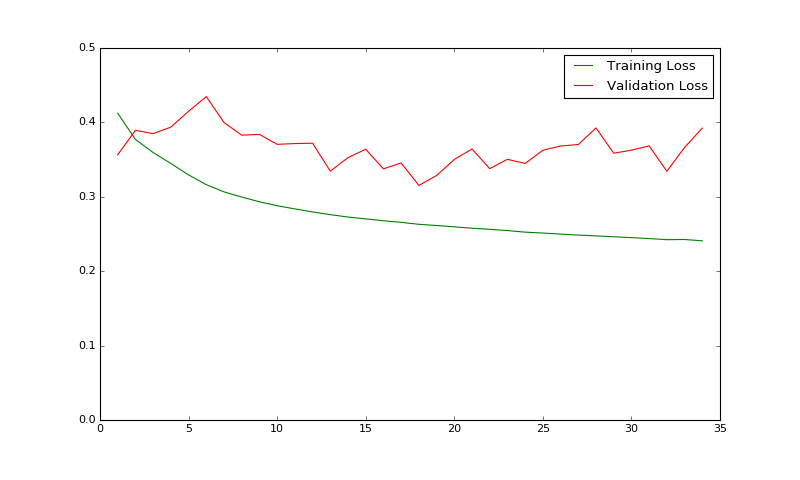

========== NN: lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.6_stack_2_conv_None
========== NN: lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.4_stack_2_conv_None


<IPython.core.display.Javascript object>


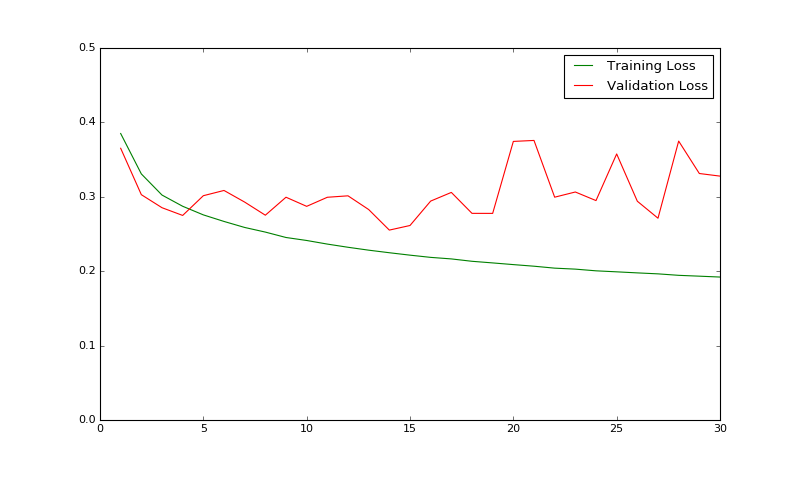

========== NN: nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True
========== NN: nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True
========== NN: lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.6_stack_1_conv_None


<IPython.core.display.Javascript object>


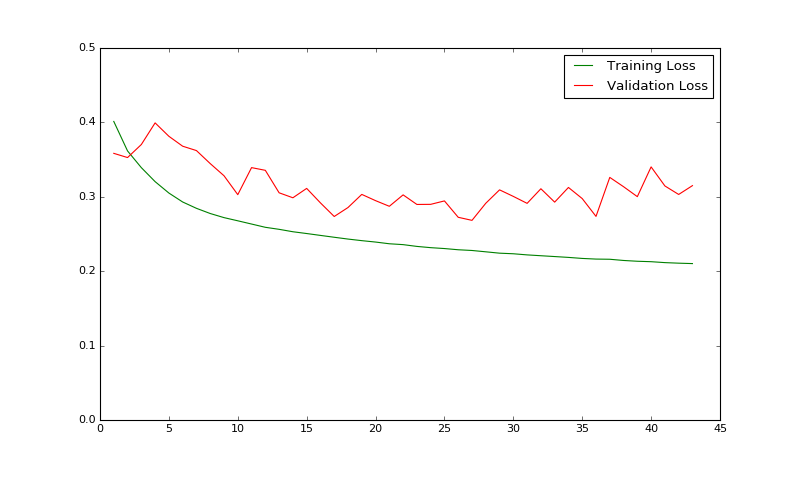

========== NN: nn_1st-size_100_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True
========== NN: nn_1st-size_200_1st-act_sigmoid_2nd-size_2000_2nd-act_tanh_in-drop_False_hid-drop_True
========== NN: lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.6_stack_1_conv_None


<IPython.core.display.Javascript object>


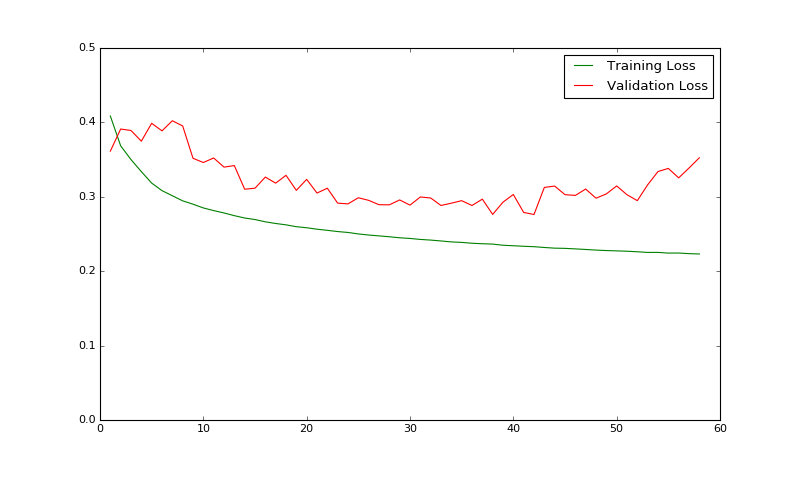

========== NN: nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True
========== NN: nn_1st-size_500_1st-act_sigmoid_2nd-size_None_2nd-act_tanh_in-drop_False_hid-drop_True
========== NN: lstm_optimizer_rmsprop_size_200_w-drop_None_u-drop_0.2_stack_1_conv_None


<IPython.core.display.Javascript object>


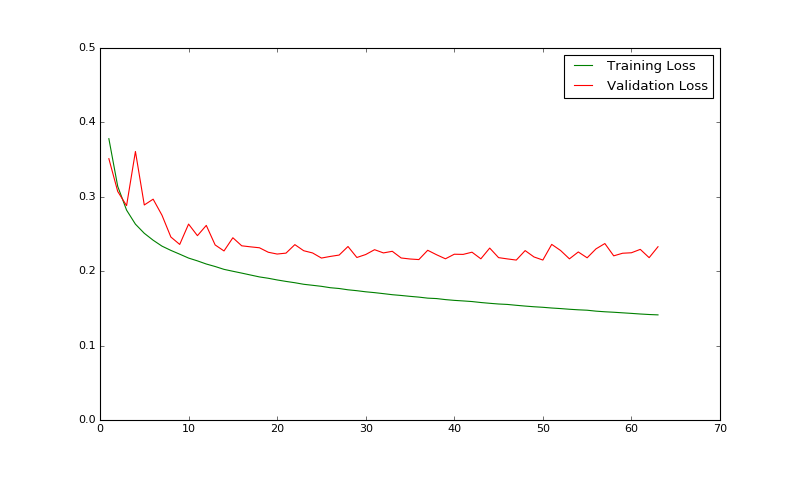

========== NN: lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.4_stack_1_conv_None


<IPython.core.display.Javascript object>


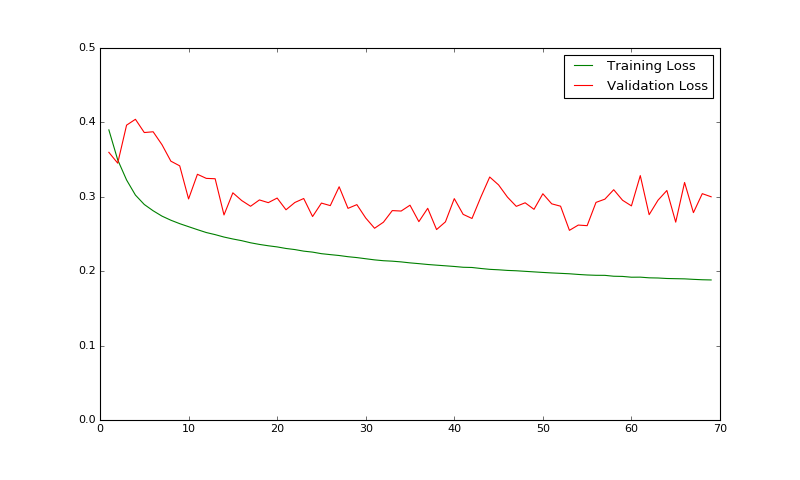

========== NN: nn_1st-size_500_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True
========== NN: lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.4_stack_1_conv_None


<IPython.core.display.Javascript object>


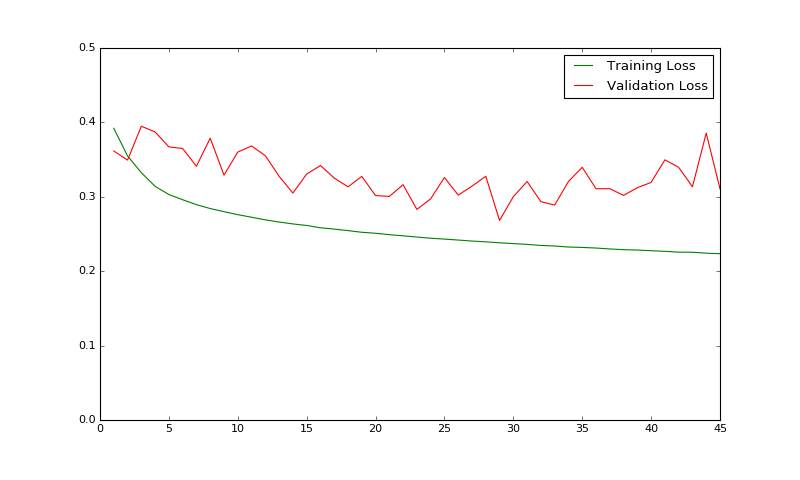

========== NN: nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True
========== NN: nn_1st-size_200_1st-act_sigmoid_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True
========== NN: nn_1st-size_200_1st-act_sigmoid_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True
========== NN: lstm_optimizer_rmsprop_size_200_w-drop_None_u-drop_0.2_stack_2_conv_None


<IPython.core.display.Javascript object>


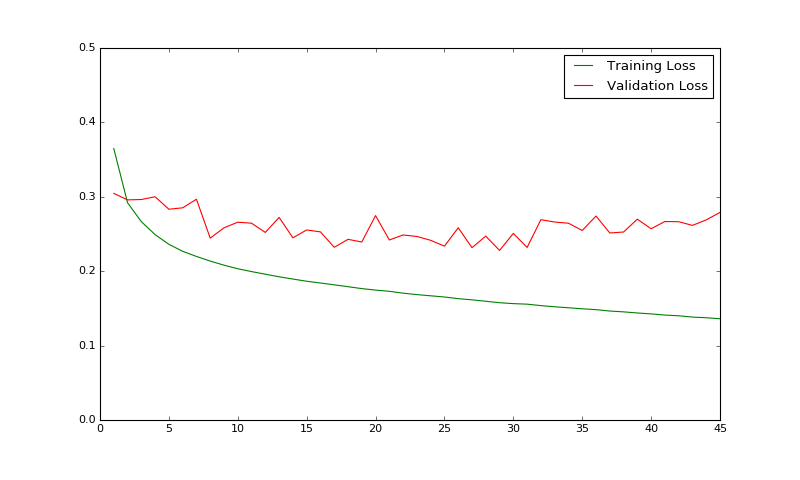

========== NN: lstm_optimizer_rmsprop_size_500_w-drop_0.6_u-drop_0.4_stack_1_conv_None
========== NN: lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.4_stack_3_conv_None


<IPython.core.display.Javascript object>


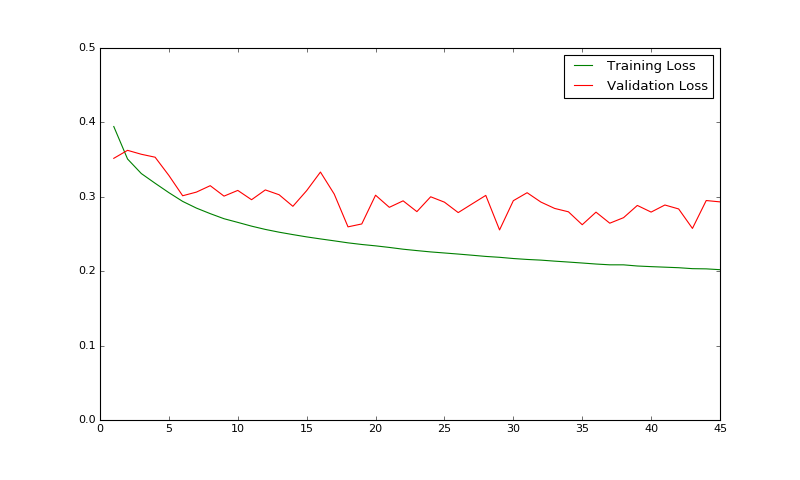

========== NN: nn_1st-size_100_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True
========== NN: nn_1st-size_500_1st-act_tanh_2nd-size_None_2nd-act_relu_in-drop_False_hid-drop_True
========== NN: lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.6_stack_1_conv_None
========== NN: nn_1st-size_500_1st-act_tanh_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True
========== NN: nn_1st-size_500_1st-act_tanh_2nd-size_None_2nd-act_tanh_in-drop_False_hid-drop_True
========== NN: lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.4_stack_2_conv_None


<IPython.core.display.Javascript object>


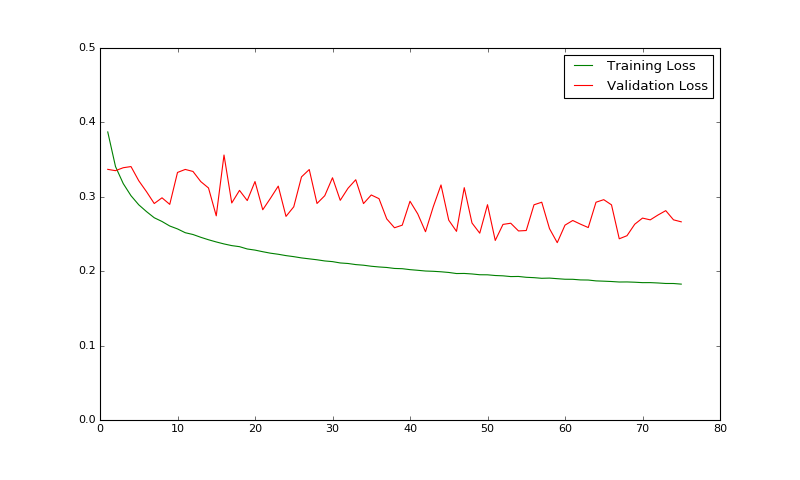

========== NN: lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.4_stack_2_conv_None


<IPython.core.display.Javascript object>


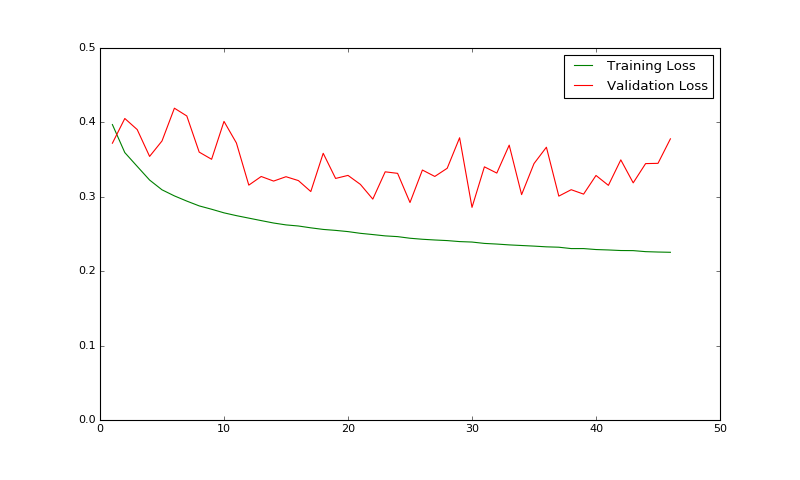

========== NN: lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_0.2_stack_2_conv_None


<IPython.core.display.Javascript object>


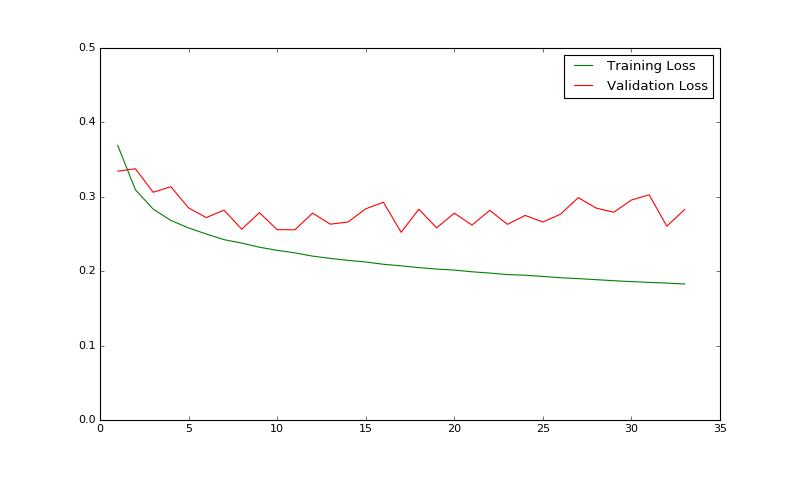

========== NN: nn_1st-size_100_1st-act_tanh_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True
========== NN: nn_1st-size_200_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


In [278]:
%matplotlib notebook
for doc2vec_method in natural_sort(get_subdirectories(nn_parameter_search_location)):
    for epoch in natural_sort(get_subdirectories(os.path.join(nn_parameter_search_location,doc2vec_method))):
        print '*********** {} -> {}'.format(doc2vec_method, epoch)
        if not os.path.exists(os.path.join(nn_parameter_search_location, doc2vec_method, epoch, NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))):
            print 'Not found'
            continue
        try:
            %time param_results_dict = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, doc2vec_method, epoch, NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'r'))
        except:
            continue
            
        for key in param_results_dict.keys():
            print('========== NN: {}'.format(key))
            val = param_results_dict[key]
            if 'training_loss' in val:
                epochs = val['epochs']
                fig = plt.figure(figsize=(10,6), dpi=80)
                ax = plt.subplot(111)
                loss_line, = ax.plot(range(1,epochs+1), val['training_loss'], 'g-', label='Training Loss')
                val_loss_line, = ax.plot(range(1,epochs+1), val['validation_loss'], 'r-', label='Validation Loss')
                ax.legend(handles=[loss_line, val_loss_line])
                ax.set_ylim((0,0.5))
                fig.canvas.draw()
            time.sleep(0.5)
            

In [393]:
standard_nn_params = pickle.load(open("/mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_all_levels_2/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/standard_nn_classes_level_1_batch_2048_nn_parameter_searches.pkl"))
lstm_params = pickle.load(open("/mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_all_levels_2/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_1_batch_2048_nn_parameter_searches.pkl"))

In [394]:
print lstm_params.keys()

['lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.5_stack_1_conv_None', 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.6_stack_3_conv_None', 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.4_stack_2_conv_None', 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.6_stack_3_conv_None', 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.6_stack_2_conv_None', 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.4_stack_2_conv_None', 'lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.6_stack_3_conv_None', 'lstm_optimizer_rmsprop_size_500_w-drop_0.6_u-drop_0.6_stack_3_conv_None', 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.6_stack_1_conv_None', 'lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.6_stack_1_conv_None', 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.4_stack_1_conv_None', 'lstm_optimizer_rmsprop_size_300_w-drop_0.5_u-drop_0.5_stack_2_conv_None', 'lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.4_stack_1_conv_None', 'lstm_optimizer_rmsprop_

In [395]:
print standard_nn_params.keys()

['nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True', 'nn_1st-size_500_1st-act_sigmoid_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True', 'nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True', 'nn_1st-size_100_1st-act_relu_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True', 'nn_1st-size_100_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True', 'nn_1st-size_100_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True', 'nn_1st-size_200_1st-act_tanh_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True', 'nn_1st-size_500_1st-act_relu_2nd-size_None_2nd-act_tanh_in-drop_False_hid-drop_True', 'nn_1st-size_100_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True', 'nn_1st-size_200_1st-act_sigmoid_2nd-size_2000_2nd-act_tanh_in-drop_False_hid-drop_True', 'nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True', 'nn_1st-size_200_1st-a

In [396]:
lstm_params.update(standard_nn_params)

In [397]:
lstm_params.keys()

['nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True',
 'nn_1st-size_500_1st-act_sigmoid_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True',
 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.5_stack_1_conv_None',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.6_stack_3_conv_None',
 'nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.4_stack_2_conv_None',
 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.6_stack_3_conv_None',
 'nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True',
 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.6_stack_2_conv_None',
 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.4_stack_2_conv_None',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.6_stack_3_conv_None',
 'lstm_optimizer_rmsprop_size_500_w-drop_0.6_u-drop_0.6_stack_3_conv_None',
 'nn_1st-size_100_1st-act_relu_

In [412]:
pickle.dump(lstm_params, open("/mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_all_levels_2/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_1_batch_2048_nn_parameter_searches.pkl", "w"))

In [410]:
for key in lstm_params.keys():
    if key.startswith("nn"):
        del lstm_params[key]

In [411]:
lstm_params.keys()

['lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.5_stack_1_conv_None',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.6_stack_3_conv_None',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.4_stack_2_conv_None',
 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.6_stack_3_conv_None',
 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.6_stack_2_conv_None',
 'lstm_optimizer_rmsprop_size_500_w-drop_0.4_u-drop_0.4_stack_2_conv_None',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.6_stack_3_conv_None',
 'lstm_optimizer_rmsprop_size_500_w-drop_0.6_u-drop_0.6_stack_3_conv_None',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.6_stack_1_conv_None',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.6_stack_1_conv_None',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.4_stack_1_conv_None',
 'lstm_optimizer_rmsprop_size_300_w-drop_0.5_u-drop_0.5_stack_2_conv_None',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.6_u-drop_0.4_stack_1_conv_None',
 'lstm_optim

## Show all found nn parameter searches

In [415]:
for directory in natural_sort(get_subdirectories(root_location)):
    if directory.startswith('nn_parameter_search_extended'):
        print '\n' + directory
        for doc2vec_method in get_subdirectories(os.path.join(root_location, directory)):
            print '\t' + doc2vec_method
            for epoch in get_subdirectories(os.path.join(root_location, directory, doc2vec_method)):
                print '\t'*2 + epoch
                for f in os.listdir(os.path.join(root_location, directory, doc2vec_method, epoch)):
                    print '\t'*3 + f



nn_parameter_search_extended
	doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None
		epoch_5
			standard_nn_sections_batch_256_nn_parameter_searches.pkl
			standard_nn_sections_batch_128_nn_parameter_searches.pkl
			standard_nn_sections_batch_512_nn_parameter_searches.pkl
			lstm_sections_batch_512_nn_parameter_searches.pkl
			standard_nn_sections_batch_1024_nn_parameter_searches.pkl
		epoch_8
			lstm_sections_batch_1024_nn_parameter_searches.pkl
			standard_nn_classes_batch_512_nn_parameter_searches.pkl
			standard_nn_sections_batch_2048_nn_parameter_searches.pkl
			standard_nn_sections_batch_256_nn_parameter_searches.pkl
			standard_nn_classes_batch_1024_nn_parameter_searches.pkl
			lstm_sections_batch_512_nn_parameter_searches.pkl
			standard_nn_subclasses_batch_512_nn_parameter_searches.pkl
			standard_nn_classes_batch_256_nn_parameter_searches.pkl

nn_parameter_search_extended_abs_desc_claims
	doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords